**Single cell samples integration**

This tutorial walks through an alignment of two groups of PBMCs from Kang et al, 2017. In this experiment, PBMCs were split into a stimulated and control group and the stimulated group was treated with interferon beta.

The response to interferon caused cell type specific gene expression changes that makes a joint analysis of all the data difficult, with cells clustering both by stimulation condition and by cell type.

Here, This tutorial will demonstrate integration strategy, as described in Stuart and Butler et al, 2018, for performing integrated analyses to promote the identification of common cell types and enable comparative analyses. While this example demonstrates the integration of two datasets (conditions), these methods have been extended to multiple datasets. This workflow provides an example of integrating four pancreatic islet datasets.

https://satijalab.org/seurat/archive/v3.0/immune_alignment.html

Link for dataset : https://www.dropbox.com/s/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip?dl=1

**Integration goals**

The following tutorial is designed to give you an overview of the kinds of comparative analyses on complex cell types that are possible using the Seurat integration procedure. Here, mahjor three main goals will be addressed:

1. Identify cell types that are present in both datasets
2. Obtain cell type markers that are conserved in both control and stimulated cells
3. Compare the datasets to find cell-type specific responses to stimulation

In [ ]:
install.packages('Seurat')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘sass’, ‘BH’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘plyr’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘bslib’, ‘spatstat.data’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘abind’, ‘tensor’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘SeuratObject’, ‘shiny’, ‘spatstat.core’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [ ]:
install.packages('cowplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("harmony")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(Seurat)
library(cowplot)
library(harmony)

Attaching SeuratObject

Loading required package: Rcpp




**Setup the Seurat objects**

The gene expression matrices can be found here. We first read in the two count matrices and set up the Seurat objects.

In [ ]:
#load data
ctrl.data <- read.table(file = "/content/immune_control_expression_matrix_copy.txt", sep = "\t")
stim.data <- read.table(file = "/content/immune_stimulated_expression_matrix_copy.txt", sep = "\t")

In [ ]:
dim(ctrl.data)
dim(stim.data)

[1] 14999 13019

[1] 14999 13019

In [ ]:
# Set up control object
ctrl <- CreateSeuratObject(counts = ctrl.data, project = "IMMUNE_CTRL", min.cells = 5)

In [ ]:
ctrl

An object of class Seurat 
6133 features across 13019 samples within 1 assay 
Active assay: RNA (6133 features, 0 variable features)

In [ ]:
# Show QC metrics for the first 5 cells
head(ctrl@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACATACATTTCC.1,IMMUNE_CTRL,1044,402
AAACATACCAGAAA.1,IMMUNE_CTRL,831,338
AAACATACCATGCA.1,IMMUNE_CTRL,258,161
AAACATACCTCGCT.1,IMMUNE_CTRL,1097,375
AAACATACCTGGTA.1,IMMUNE_CTRL,1156,486


In [ ]:
#add column with sample information
ctrl$stim <- "CTRL"

# Show QC metrics for the first 5 cells
head(ctrl@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,stim
,<fct>,<dbl>,<int>,<chr>
AAACATACATTTCC.1,IMMUNE_CTRL,1044,402,CTRL
AAACATACCAGAAA.1,IMMUNE_CTRL,831,338,CTRL
AAACATACCATGCA.1,IMMUNE_CTRL,258,161,CTRL
AAACATACCTCGCT.1,IMMUNE_CTRL,1097,375,CTRL
AAACATACCTGGTA.1,IMMUNE_CTRL,1156,486,CTRL


In [ ]:
# remove low quality cells
ctrl <- subset(ctrl, subset = nFeature_RNA > 250)
# Show QC metrics for the first 5 cells
head(ctrl@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,stim
,<fct>,<dbl>,<int>,<chr>
AAACATACATTTCC.1,IMMUNE_CTRL,1044,402,CTRL
AAACATACCAGAAA.1,IMMUNE_CTRL,831,338,CTRL
AAACATACCTCGCT.1,IMMUNE_CTRL,1097,375,CTRL
AAACATACCTGGTA.1,IMMUNE_CTRL,1156,486,CTRL
AAACATACGATGAA.1,IMMUNE_CTRL,686,289,CTRL


In [ ]:
#normalize data
ctrl_norm <- NormalizeData(ctrl, verbose = FALSE)
# Show QC metrics for the first 5 cells
head(ctrl_norm@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,stim
,<fct>,<dbl>,<int>,<chr>
AAACATACATTTCC.1,IMMUNE_CTRL,1044,402,CTRL
AAACATACCAGAAA.1,IMMUNE_CTRL,831,338,CTRL
AAACATACCTCGCT.1,IMMUNE_CTRL,1097,375,CTRL
AAACATACCTGGTA.1,IMMUNE_CTRL,1156,486,CTRL
AAACATACGATGAA.1,IMMUNE_CTRL,686,289,CTRL


In [ ]:
#get higher variable features
ctrl_hv <- FindVariableFeatures(ctrl_norm, selection.method = "vst", nfeatures = 2000)

# Show QC metrics for the first 5 cells
head(ctrl_hv@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,stim
,<fct>,<dbl>,<int>,<chr>
AAACATACATTTCC.1,IMMUNE_CTRL,1044,402,CTRL
AAACATACCAGAAA.1,IMMUNE_CTRL,831,338,CTRL
AAACATACCTCGCT.1,IMMUNE_CTRL,1097,375,CTRL
AAACATACCTGGTA.1,IMMUNE_CTRL,1156,486,CTRL
AAACATACGATGAA.1,IMMUNE_CTRL,686,289,CTRL


**Set up stimulated object**

In [ ]:
# Set up stimulated object
stim <- CreateSeuratObject(counts = stim.data, project = "IMMUNE_STIM", min.cells = 5)
stim$stim <- "STIM"

In [ ]:
#remove low QC cells
stim <- subset(stim, subset = nFeature_RNA > 250)


In [ ]:
#Normalize data
stim_norm <- NormalizeData(stim, verbose = FALSE)

In [ ]:
#Get higher variable features
stim_hv <- FindVariableFeatures(stim_norm, selection.method = "vst", nfeatures = 2000)

# Show QC metrics for the first 5 cells
head(stim_hv@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,stim
,<fct>,<dbl>,<int>,<chr>
AAACATACATTTCC.1,IMMUNE_STIM,1044,402,STIM
AAACATACCAGAAA.1,IMMUNE_STIM,831,338,STIM
AAACATACCTCGCT.1,IMMUNE_STIM,1097,375,STIM
AAACATACCTGGTA.1,IMMUNE_STIM,1156,486,STIM
AAACATACGATGAA.1,IMMUNE_STIM,686,289,STIM


**Perform integration**

Here, we will identify anchors using the `FindIntegrationAnchors` function, which takes a list of Seurat objects as input, and use these anchors to integrate the two datasets together with IntegrateData.

In [ ]:
immune.anchors <- FindIntegrationAnchors(object.list = list(ctrl_hv, stim_hv), dims = 1:20)
immune.anchors

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14807 anchors

Filtering anchors

	Retained 10404 anchors



An AnchorSet object containing 20808 anchors between 2 Seurat objects 
 This can be used as input to IntegrateData.

In [ ]:
immune.combined <- IntegrateData(anchorset = immune.anchors, dims = 1:20)

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [ ]:
DefaultAssay(immune.combined) <- "integrated"


**Perform an integrated analysis**

Now we can run a single integrated analysis on all cells

In [ ]:
# Run the standard workflow for visualization and clustering
immune.combined_scaled <- ScaleData(immune.combined, verbose = FALSE)


In [ ]:
#perform PCA
immune.combined_pca <- RunPCA(immune.combined_scaled, npcs = 50, verbose = FALSE)

**Remove Batch Effect**

Run `harmony` or `RunFastMNN` to remove batch effect

In [ ]:
#Run harmony to remove batch effect
immune.combined_b <- RunHarmony(immune.combined_pca, group.by.vars = "stim", assay.use='integrated')


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.integrated.harmony; see ?make.names for more details on syntax validity”


In [ ]:
# Run UMAP 
immune.combined_umap <- RunUMAP(immune.combined_b, reduction = "pca", dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:53:48 UMAP embedding parameters a = 0.9922 b = 1.112

10:53:48 Read 9760 rows and found 20 numeric columns

10:53:48 Using Annoy for neighbor search, n_neighbors = 30

10:53:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:53:49 Writing NN index file to temp file /tmp/RtmpVFiDam/file441424627c

10:53:49 Searching Annoy index using 1 thread, search_k = 3000

10:53:53 Annoy recall = 100%

10:53:54 Commencing smooth kNN distance calibration using 1 thread

10:53:55 Initializing from 

**Clustering**

Graph based clustering using shared nearest neighbours 
here, first it find nearest neighbours

In [ ]:
# Run Clustering
immune.combined_neighbour <- FindNeighbors(immune.combined_umap, reduction = "pca", dims = 1:20)
immune.combined_clus <- FindClusters(immune.combined_neighbour, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9760
Number of edges: 358411

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8794
Number of communities: 14
Elapsed time: 1 seconds


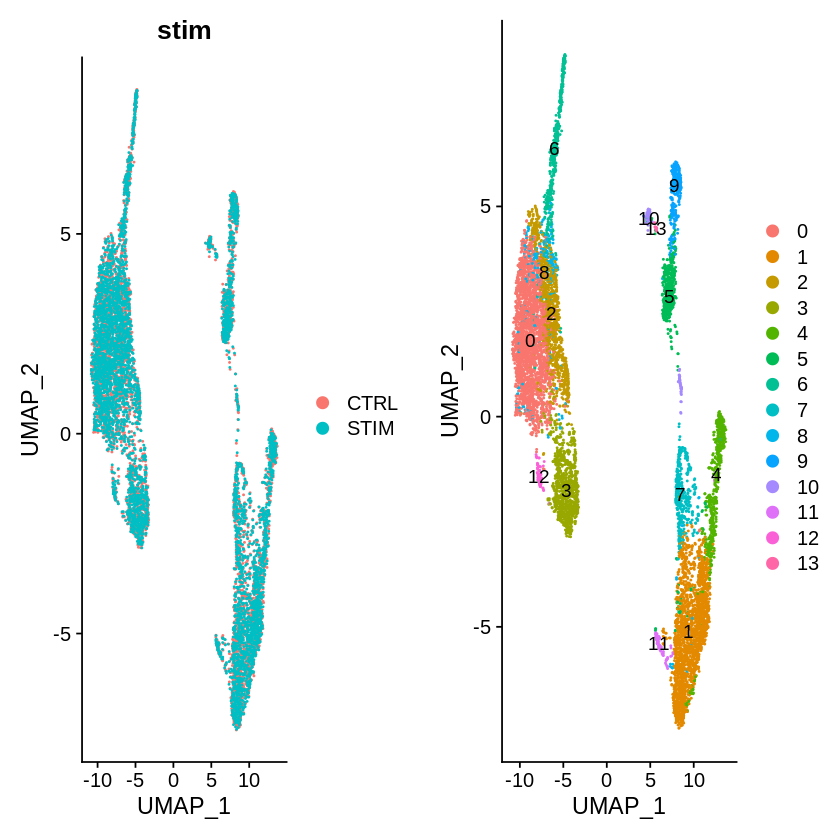

In [ ]:
# Visualization
p1 <- DimPlot(immune.combined_clus, reduction = "umap", group.by = "stim")
p2 <- DimPlot(immune.combined_clus, reduction = "umap", label = TRUE)
plot_grid(p1, p2)

To visualize the two conditions side-by-side, we can use the split.by argument to show each condition colored by cluster.

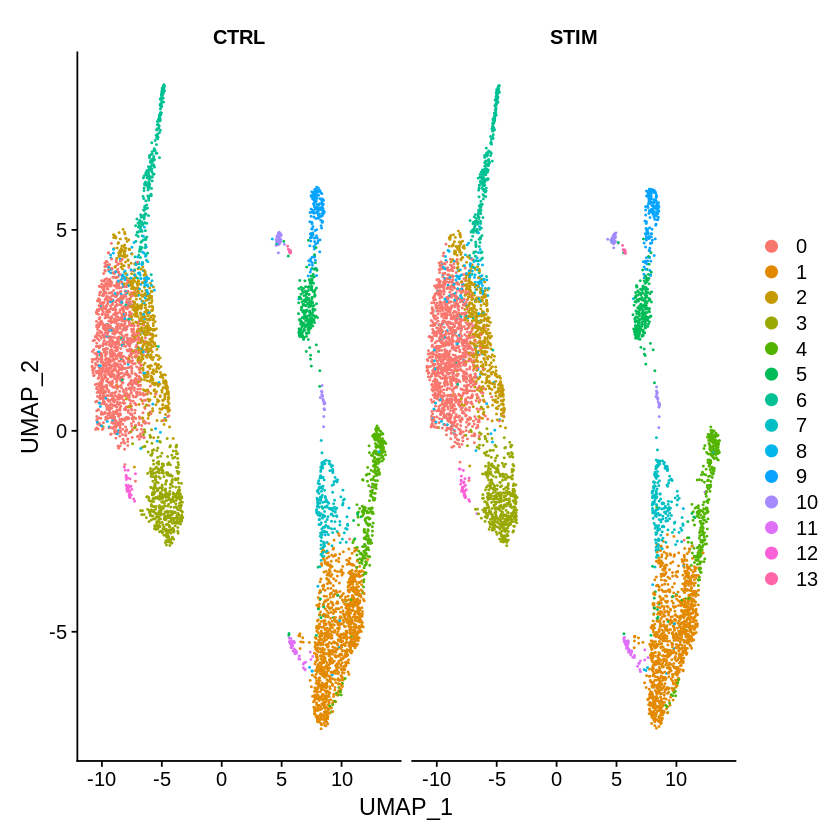

In [ ]:
DimPlot(immune.combined_clus, reduction = "umap", split.by = "stim")


**Identify conserved cell type markers**

To identify canonical cell type marker genes that are conserved across conditions, we provide the FindConservedMarkers function. This function performs differential gene expression testing for each dataset/group and combines the p-values using meta-analysis methods from the MetaDE R package. For example, we can calculated the genes that are conserved markers irrespective of stimulation condition in cluster 7 (NK cells).

In [ ]:
DefaultAssay(immune.combined_clus) <- "RNA"

In [ ]:
install.packages("BiocManager")
BiocManager::install("multtest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'multtest'

also installing the dependencies ‘BiocGenerics’, ‘Biobase’


Old packages: 'broom', 'cpp11', 'gert', 'glue', 'openssl', 'sessioninfo',
  'tibble', 'tinytex', 'uuid', 'xfun', 'nlme'



In [ ]:
install.packages("BiocManager")
BiocManager::install("metap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'metap'

also installing the dependencies ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘pROC’, ‘recipes’, ‘caret’, ‘tmvnsim’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘mnormt’, ‘numDeriv’, ‘quantreg’, ‘TH.data’, ‘sandwich’, ‘rbibutils’, ‘sn’, ‘mvtnorm’, ‘plotrix’, ‘multcomp’, ‘Rdpack’, ‘TFisher’, ‘mutoss’, ‘mathjaxr’


Old packages: 'broom', 'cpp11', 'gert', 'glue', 'openssl', 'sessioninfo',
  'tibble', 'tinytex', 'uuid', 'xfun', 'nlme'



In [ ]:
library(metap)

In [ ]:
nk.markers <- FindConservedMarkers(immune.combined_clus, ident.1 = 7, grouping.var = "stim", verbose = FALSE)
head(nk.markers)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,CTRL_p_val,CTRL_avg_log2FC,CTRL_pct.1,CTRL_pct.2,CTRL_p_val_adj,STIM_p_val,STIM_avg_log2FC,STIM_pct.1,STIM_pct.2,STIM_p_val_adj,max_pval,minimump_p_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SNHG12,1.331250e-177,3.071638,0.416,0.022,8.164558e-174,3.538090e-185,3.112897,0.422,0.022,2.169911e-181,1.331250e-177,7.076180e-185
PRR7,3.872336e-110,2.284527,0.223,0.009,2.374904e-106,6.571950e-109,2.272488,0.221,0.009,4.030577e-105,6.571950e-109,7.744672e-110
SNHG15,4.656030e-102,2.936867,0.447,0.057,2.855543e-98,1.016864e-100,2.923069,0.442,0.057,6.236424e-97,1.016864e-100,9.312061e-102
NR4A2,5.453570e-99,2.973547,0.320,0.027,3.344674e-95,8.641614e-98,2.959973,0.317,0.027,5.299902e-94,8.641614e-98,1.090714e-98
NOP58,3.132494e-92,2.702216,0.548,0.099,1.921159e-88,5.252754e-93,2.699532,0.548,0.098,3.221514e-89,3.132494e-92,1.050551e-92
CACYBP,6.685789e-92,3.182426,0.827,0.309,4.100394e-88,1.126340e-91,3.171244,0.824,0.309,6.907842e-88,1.126340e-91,1.337158e-91


We can explore these marker genes for each cluster and use them to annotate our clusters as specific cell types.

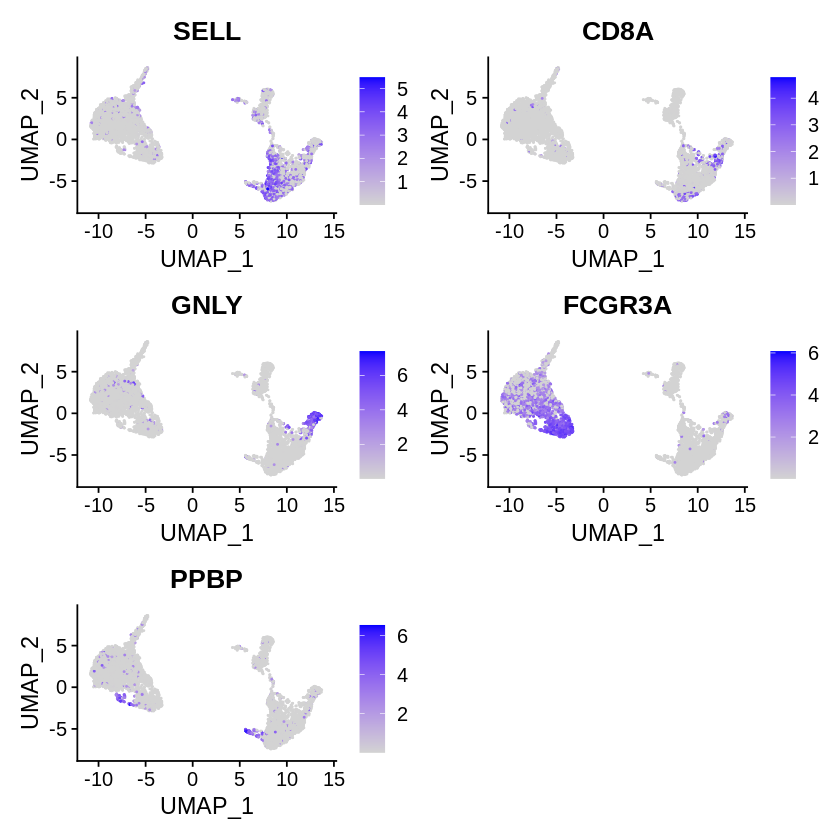

In [ ]:
FeaturePlot(immune.combined_clus, features = c( "SELL",  "CD8A", "GNLY",  "FCGR3A", "PPBP"), min.cutoff = "q9")

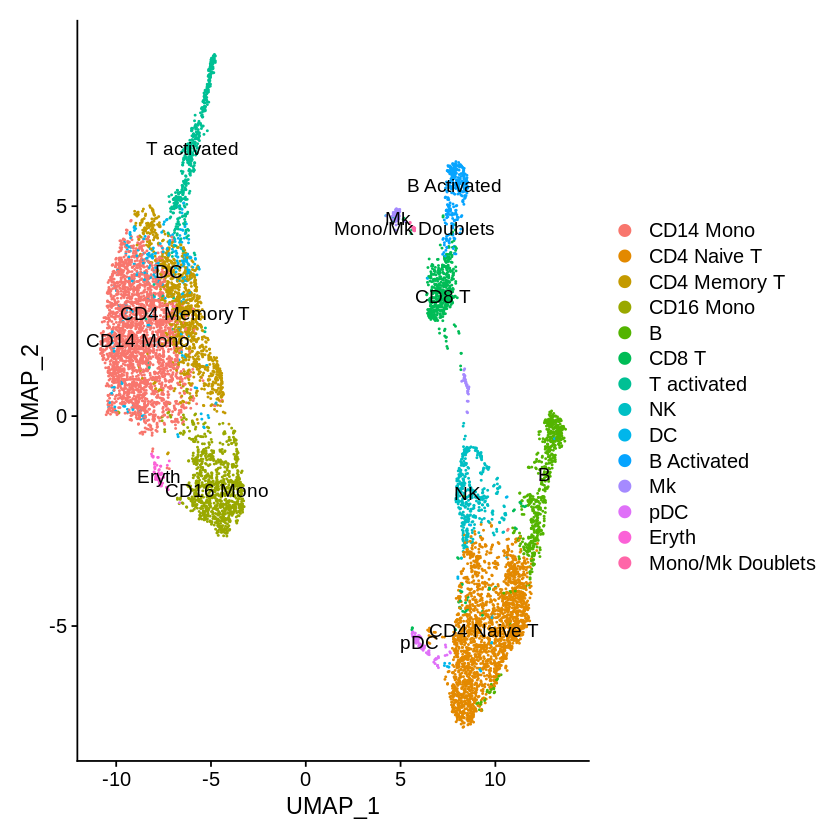

In [ ]:
immune.combined_clus1 <- RenameIdents(immune.combined_clus, `0` = "CD14 Mono", `1` = "CD4 Naive T", `2` = "CD4 Memory T", 
    `3` = "CD16 Mono", `4` = "B", `5` = "CD8 T", `6` = "T activated", `7` = "NK", `8` = "DC", `9` = "B Activated", 
    `10` = "Mk", `11` = "pDC", `12` = "Eryth", `13` = "Mono/Mk Doublets")

DimPlot(immune.combined_clus1, label = TRUE)

The DotPlot function with the split.by parameter can be useful for viewing conserved cell type markers across conditions, showing both the expression level and the percentage of cells in a cluster expressing any given gene. Here we plot 2-3 strong marker genes for each of our 10 clusters.

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: CCL5, NKG7, HSPH1”


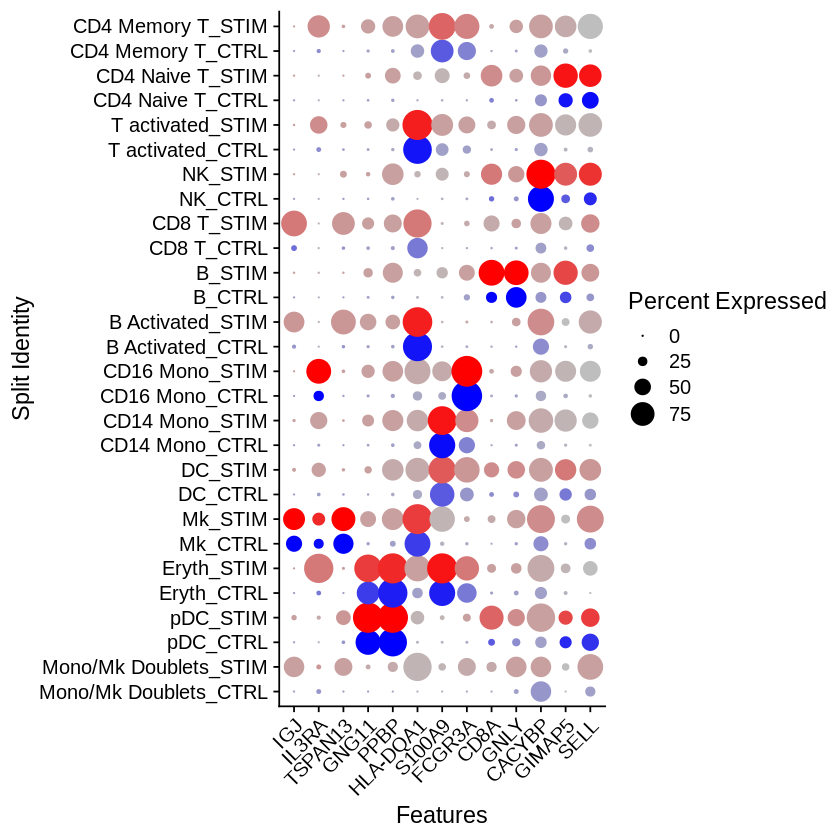

In [ ]:
Idents(immune.combined_clus1) <- factor(Idents(immune.combined_clus1), levels = c("Mono/Mk Doublets", "pDC", 
    "Eryth", "Mk", "DC", "CD14 Mono", "CD16 Mono", "B Activated", "B", "CD8 T", "NK", "T activated", 
    "CD4 Naive T", "CD4 Memory T"))
markers.to.plot <- c("HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5", 
    "CD8A",  "FCGR3A", "S100A9", "HLA-DQA1", "PPBP", "GNG11",  "TSPAN13", "IL3RA", "IGJ")
DotPlot(immune.combined_clus1, features = rev(markers.to.plot), cols = c("blue", "red"), dot.scale = 8, 
    split.by = "stim") + RotatedAxis()

**Identify differential expressed genes across conditions**

Now that we’ve aligned the stimulated and control cells, we can start to do comparative analyses and look at the differences induced by stimulation. One way to look broadly at these changes is to plot the average expression of both the stimulated and control cells and look for genes that are visual outliers on a scatter plot. Here, we take the average expression of both the stimulated and control naive T cells and CD14 monocyte populations and generate the scatter plots, highlighting genes that exhibit dramatic responses to interferon stimulation.

**genes change in different conditions for cells**

We can ask what genes change in different conditions for cells of the same type.

First, we create a column in the meta.data slot to hold both the cell type and stimulation information and switch the current ident to that column.

Then we use FindMarkers to find the genes that are different between stimulated and control B cells. Notice that many of the top genes that show up here are the same as the ones we plotted earlier as core interferon response genes. Additionally, genes that were specific to a cell type, e.g. B, T cells, etc can be identified.

In [ ]:
immune.combined_clus1$celltype.stim <- paste(Idents(immune.combined_clus1), immune.combined_clus1$stim, sep = "_")
immune.combined_clus1$celltype <- Idents(immune.combined_clus1)
Idents(immune.combined_clus1) <- "celltype.stim"


In [ ]:
head(immune.combined_clus1@meta.data,10)

,orig.ident,nCount_RNA,nFeature_RNA,stim,integrated_snn_res.0.5,seurat_clusters,celltype.stim,celltype
,<chr>,<dbl>,<int>,<chr>,<fct>,<fct>,<chr>,<fct>
AAACATACATTTCC.1_1,IMMUNE_CTRL,1044,402,CTRL,2,2,CD4 Memory T_CTRL,CD4 Memory T
AAACATACCAGAAA.1_1,IMMUNE_CTRL,831,338,CTRL,2,2,CD4 Memory T_CTRL,CD4 Memory T
AAACATACCTCGCT.1_1,IMMUNE_CTRL,1097,375,CTRL,0,0,CD14 Mono_CTRL,CD14 Mono
AAACATACCTGGTA.1_1,IMMUNE_CTRL,1156,486,CTRL,10,10,Mk_CTRL,Mk
AAACATACGATGAA.1_1,IMMUNE_CTRL,686,289,CTRL,1,1,CD4 Naive T_CTRL,CD4 Naive T
AAACATACTGCGTA.1_1,IMMUNE_CTRL,1054,455,CTRL,7,7,NK_CTRL,NK
AAACATACTGCTGA.1_1,IMMUNE_CTRL,565,267,CTRL,1,1,CD4 Naive T_CTRL,CD4 Naive T
AAACATTGAGTGTC.1_1,IMMUNE_CTRL,880,394,CTRL,5,5,CD8 T_CTRL,CD8 T
AAACATTGCTTCGC.1_1,IMMUNE_CTRL,689,290,CTRL,0,0,CD14 Mono_CTRL,CD14 Mono


In [ ]:
MK.response <- FindMarkers(immune.combined_clus1, ident.1 = "Mk_STIM", ident.2 = "Mk_CTRL", verbose = FALSE)
head(MK.response, n = 15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCDC30,3.730182e-09,-0.3412227,0.737,0.018,7.460364e-06
IL8,2.467857e-08,1.0061783,0.895,0.125,4.935714e-05
S100A8,4.888264e-07,0.7667280,0.772,0.054,9.776529e-04
ZEB2,9.058018e-05,0.3560083,0.614,0.054,1.811604e-01
IER3,1.791828e-04,0.2950196,0.211,0.018,3.583656e-01
GNPDA1,1.995430e-03,-0.2546856,0.368,0.036,1.000000e+00
TLR2,3.896359e-03,0.5679691,0.140,0.000,1.000000e+00
KPNA6,1.324643e-02,0.2654277,0.667,0.089,1.000000e+00
LTB,2.686237e-01,-0.2742833,0.596,0.357,1.000000e+00



Another useful way to visualize these changes in gene expression is with the split.by option to the FeaturePlot or VlnPlot function. This will display FeaturePlots of the list of given genes, split by a grouping variable (stimulation condition here). Genes such as CD3D and GNLY are canonical cell type markers (for T cells and NK/CD8 T cells) that are virtually unaffected by interferon stimulation and display similar gene expression patterns in the control and stimulated group. IFI6 and ISG15, on the other hand, are core interferon response genes and are upregulated accordingly in all cell types. Finally, CD14 and CXCL10 are genes that show a cell type specific interferon response. CD14 expression decreases after stimulation in CD14 monocytes, which could lead to misclassification in a supervised analysis framework, underscoring the value of integrated analysis. CXCL10 shows a distinct upregulation in monocytes and B cells after interferon stimulation but not in other cell types.

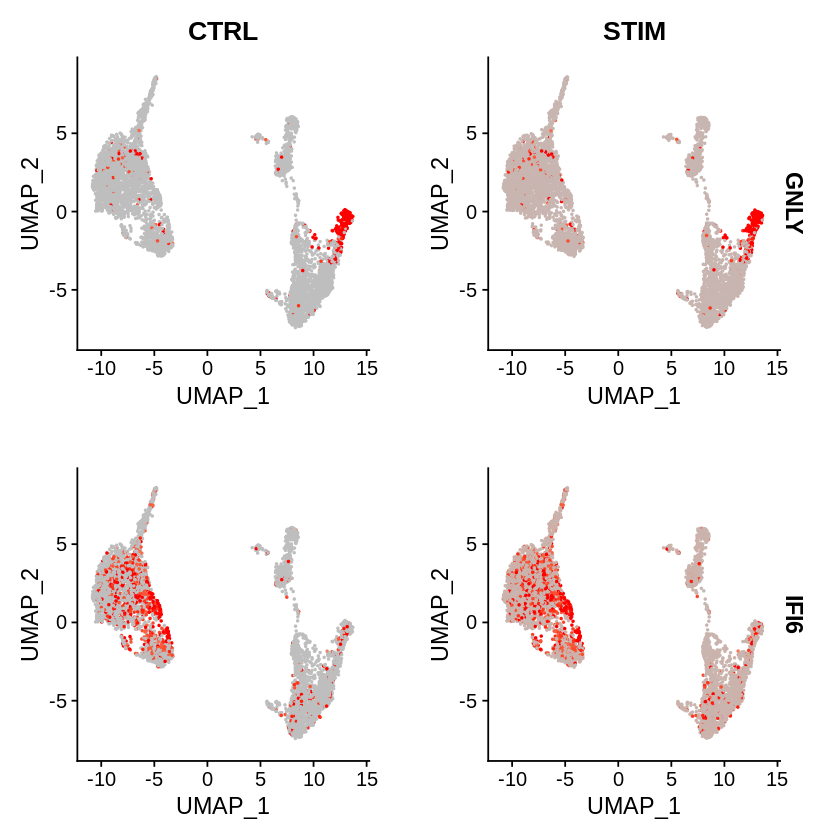

In [ ]:
FeaturePlot(immune.combined_clus1, features = c("GNLY", "IFI6"), split.by = "stim", max.cutoff = 3, 
    cols = c("grey", "red"))

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: LYZ”
Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


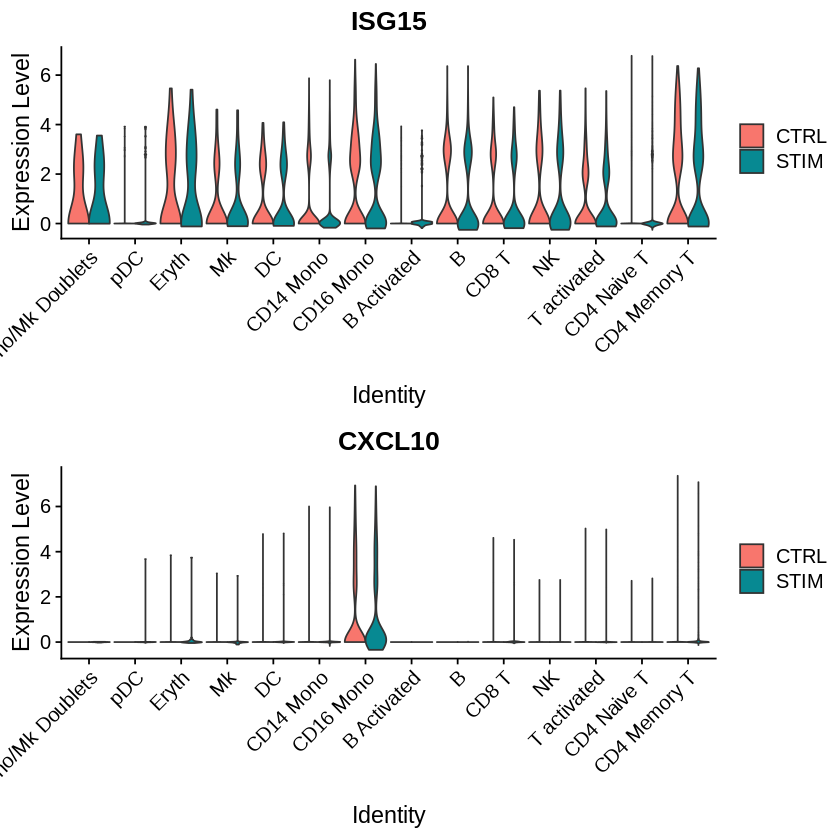

In [ ]:
plots <- VlnPlot(immune.combined_clus1, features = c("LYZ", "ISG15", "CXCL10"), split.by = "stim", group.by = "celltype", 
    pt.size = 0, combine = FALSE)
CombinePlots(plots = plots, ncol = 1)